# Introduction to reranking: an advanced RAG technique

In this notebook, you will test an advanced RAG technique: using a reranker (CrossEncoder model) to improve the retrieval of news in a RAG pipeline.

The notebook is partially filled with code. You will complete it by writing the missing code, running evaluations, and comparing results.

# 📌 Objectives

By the end of this notebook, students will be able to:

1. **Create and Use a Synthetic Evaluation Dataset:**
   - Automatically generate natural language questions corresponding to news articles using an LLM.
   - Construct a test set to assess the quality of retrieved answers.

2. **Evaluate Baseline RAG Performance Without Reranking:**
   - Measure how often the original article appears in the top-k results using FAISS alone.
   - Record retrieval accuracy and position for each query.

3. **Apply a Cross-Encoder Reranker to Improve Retrieval:**
   - Use a pretrained CrossEncoder model to rerank top FAISS results.
   - Evaluate improvements in the ranking of correct articles after reranking.

4. **Compare Retrieval Performance With and Without Reranking:**
   - Compute and visualize differences in rank positions before and after reranking.
   - Analyze statistical improvements (e.g., average rank, frequency at position 0).

5. **Reflect on the Impact of Reranking in RAG Pipelines:**
   - Discuss how reranking enhances retrieval quality in a RAG context.
   - Identify scenarios where reranking may offer the most value, and propose further improvements.


## Install and Import librairies
Run the following cell to install required libraries. These include `sentence-transformers` for embeddings and reranking, and `faiss-cpu` for vector similarity search.

In [ ]:
%pip install sentence-transformers
%pip install faiss-cpu

In [ ]:
from sentence_transformers import SentenceTransformer
import faiss
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
import matplotlib.pyplot as plt
import faiss
import os
import random

## Load S&P 500 news
We will work with a dataset of financial news headlines and summaries. You will:
 - Load the data
 - Convert the publication date column to datetime
 - Drop duplicate summaries

In [ ]:
import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')
DIR = "/content/drive/MyDrive/Colab Notebooks/MNA/FZ4025 - Fintech e innovación digital en finanzas/Week 5/"
os.chdir(DIR)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_news = pd.read_csv('df_news.csv')
df_news['PUBLICATION_DATE'] = pd.to_datetime(df_news['PUBLICATION_DATE']).dt.date
display(df_news)
print(df_news.shape)

df_news.drop_duplicates('SUMMARY', inplace=True)
print(df_news.shape)

,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,PROVIDER,URL
0,MMM,2 Dow Jones Stocks with Promising Prospects an...,The Dow Jones (^DJI) is made up of 30 of the m...,2025-05-29,StockStory,https://finance.yahoo.com/news/2-dow-jones-sto...
1,MMM,3 S&P 500 Stocks Skating on Thin Ice,The S&P 500 (^GSPC) is often seen as a benchma...,2025-05-27,StockStory,https://finance.yahoo.com/news/3-p-500-stocks-...
2,MMM,3M Rises 15.8% YTD: Should You Buy the Stock N...,"MMM is making strides in the aerospace, indust...",2025-05-22,Zacks,https://finance.yahoo.com/news/3m-rises-15-8-y...
3,MMM,Q1 Earnings Roundup: 3M (NYSE:MMM) And The Res...,Quarterly earnings results are a good time to ...,2025-05-22,StockStory,https://finance.yahoo.com/news/q1-earnings-rou...
4,MMM,3 Cash-Producing Stocks with Questionable Fund...,While strong cash flow is a key indicator of s...,2025-05-19,StockStory,https://finance.yahoo.com/news/3-cash-producin...
...,...,...,...,...,...,...
4866,ZTS,2 Dividend Stocks to Buy With $500 and Hold Fo...,Zoetis is a leading animal health company with...,2025-05-23,Motley Fool,https://www.fool.com/investing/2025/05/23/2-di...
4867,ZTS,Zoetis (NYSE:ZTS) Declares US$0.50 Dividend Pe...,Zoetis (NYSE:ZTS) recently affirmed a dividend...,2025-05-22,Simply Wall St.,https://finance.yahoo.com/news/zoetis-nyse-zts...
4868,ZTS,Jim Cramer on Zoetis (ZTS): “It Does Seem to B...,We recently published a list of Jim Cramer Tal...,2025-05-21,Insider Monkey,https://finance.yahoo.com/news/jim-cramer-zoet...
4869,ZTS,Zoetis (ZTS) Upgraded to Buy: Here's Why,Zoetis (ZTS) might move higher on growing opti...,2025-05-21,Zacks,https://finance.yahoo.com/news/zoetis-zts-upgr...


(4871, 6)
(3976, 6)


## Implement a Faiss Vector Store with Sentence Transfomer embeddings
This section is already implemented. It uses a sentence transformer to encode news summaries into vector embeddings and stores them in a FAISS index.

We also define a simple class `FaissVectorStore` that allows for efficient retrieval.


In [ ]:
df_news['EMBEDDED_TEXT'] = df_news['TITLE'] + ' : ' + df_news['SUMMARY']

In [ ]:
model = SentenceTransformer('all-MiniLM-L6-v2')

In [ ]:
# Load model and compute embeddings
text_embeddings = model.encode(df_news['SUMMARY'].tolist(), convert_to_numpy=True)

# Normalize embeddings to use cosine similarity (via inner product in FAISS)
text_embeddings = text_embeddings / np.linalg.norm(text_embeddings, axis=1, keepdims=True)

# Prepare metadata
documents = df_news['SUMMARY'].tolist()
metadata = [
    {
        'PUBLICATION_DATE': row['PUBLICATION_DATE'],
        'TICKER': row['TICKER'],
        'PROVIDER': row['PROVIDER']
    }
    for _, row in df_news.iterrows()
]

In [ ]:
embedding_dim = text_embeddings.shape[1]
faiss_index = faiss.IndexFlatIP(embedding_dim)  # Cosine similarity via inner product
faiss_index.add(text_embeddings)

In [ ]:
class FaissVectorStore:
    def __init__(self, model, index, embeddings, documents, metadata):
        self.model = model
        self.index = index
        self.embeddings = embeddings
        self.documents = documents
        self.metadata = metadata

    def search(self, query, k=5, metadata_filter=None):
        query_embedding = self.model.encode([query])
        query_embedding = query_embedding / np.linalg.norm(query_embedding)

        if metadata_filter:
            filtered_indices = [i for i, meta in enumerate(self.metadata) if metadata_filter(meta)]
            if not filtered_indices:
                return []
            filtered_embeddings = self.embeddings[filtered_indices]
            temp_index = faiss.IndexFlatIP(filtered_embeddings.shape[1])
            temp_index.add(filtered_embeddings)
            D, I = temp_index.search(query_embedding, k)
            indices = [filtered_indices[i] for i in I[0]]
        else:
            D, I = self.index.search(query_embedding, k)
            indices = I[0]
            D = D[0]

        results = []
        for idx, sim in zip(indices, D):
            results.append((self.documents[idx], self.metadata[idx], float(sim)))


        return results

In [ ]:
# Create FAISS-based store
faiss_store = FaissVectorStore(
    model=model,
    index=faiss_index,
    embeddings=text_embeddings,
    documents=documents,
    metadata=metadata
)

## Creating a dataset to evaluate the reranking

👉 **Instructions**:
- In this section, we will create an evaluation dataset for reranking by:
  - Sampling **100** distinct news articles from the full dataset.
  - Generating **one natural question** per article using GPT, where the expected answer is the original article.

✅ By the end of this section, you'll have a new DataFrame (`df_news_questions`) with:
- `NEWS`: the original summary
- `QUESTION`: the corresponding question generated using GPT

> ℹ️ The generated questions will simulate user queries in a RAG pipeline.

In [ ]:
# CODE HERE
# Use as many coding cells as you need

df_sample = df_news.sample(n=100, random_state=42).reset_index(drop=True)

### Create OpenAI connector
You’ll use OpenAI’s GPT model to generate natural questions corresponding to each sampled news summary. These questions will be used to test the retrieval system.

✅ This cell contains an API key for demonstration purposes. You **must** use your own API key when running this notebook.


In [ ]:
from openai import OpenAI
from google.colab import userdata
OPENAI_API_KEY = userdata.get("OPENAI_API_KEY")
client = OpenAI(api_key=OPENAI_API_KEY)

response = client.responses.create(
    model="gpt-4o-mini",
    input="Write a one-sentence bedtime story about a unicorn."
)

print(response.output_text)

As the shimmering moonlight bathed the enchanted forest, a gentle unicorn with a sparkling mane danced among the twinkling fireflies, whispering sweet dreams to every creature tucked in for the night.


### Using GPT to generate a question based on a news
Based on the instruction above, you need to use GPT to create a evaluation dataset.

**Clarification** Specifically, the goal is to generate a natural question whose correct answer is the news summary. For example, if the news is about a company announcing layoffs, a good question could be: ‘Which company recently announced job cuts in its tech division?


In [ ]:
prompt = """
Given the news headline provided below,
give me a question that would justify retrieving this specific news headline in a RAG system

News headlines:
{news}

Give me a question for which the answer is the news headline:
QUESTION

**Important**
dont answer anything else other than the question!
"""

In [ ]:
# CODE HERE
# Use as many coding cells as you need

questions = []
for i, row in df_sample.iterrows():
    news_text = row['SUMMARY']
    full_prompt = prompt.format(news=news_text)

    response = client.responses.create(
        model="gpt-4o-mini",
        input=full_prompt,
        temperature=0.7
    )
    questions.append(response.output_text.strip())

# Create evaluation dataset
df_news_questions = pd.DataFrame({
    "NEWS": df_sample['SUMMARY'],
    "QUESTION": questions
})

df_news_questions.head()

,NEWS,QUESTION
0,"Broadcom, Arista Networks initiated: Wall Stre...",What are the latest analyst recommendations fo...
1,Emerson Electric (EMR) has received quite a bi...,What recent developments have made Emerson Ele...
2,Ventas (VTR) reported earnings 30 days ago. Wh...,What recent news discusses Ventas (VTR)'s earn...
3,Nvidia's earnings call this week will be a mar...,What are the key factors to consider for Nvidi...
4,Inflation-scarred American consumers are putti...,What are American consumers doing in response ...


## Evaluating RAG without and with reranking

You will now compare a basic RAG pipeline using FAISS with an enhanced version that includes reranking.


### RAG without reranking

👉 **Instructions**:
1. Implement a function that retrieves the **top 5** news summaries for a given question using your FAISS vector store.
2. For each `(QUESTION, NEWS)` pair:
   - Search using the `QUESTION`
   - Check if the corresponding `NEWS` appears in the top 5 retrieved summaries.
   - Record the **rank position** (from 0 to 4) in a new column `NO_RERANKER`.
   - If the news is **not found**, store `'not found'`.

✅ This step helps measure the baseline performance of your vector-based retrieval without reranking.

> 💡 Tip: You can store the retrieved results in a dictionary or list to avoid recomputation.

In [ ]:
# CODE HERE
# Use as many coding cells as you need

class RAGNoReranker:
    def __init__(self, faiss_index, embeddings, summaries, model_name='all-MiniLM-L6-v2'):
        self.index = faiss_index
        self.embeddings = embeddings
        self.summaries = summaries
        self.encoder = SentenceTransformer(model_name)

    def retrieve_top_k(self, query, k=5):
        query_vec = self.encoder.encode([query], convert_to_numpy=True)
        query_vec = query_vec / np.linalg.norm(query_vec, axis=1, keepdims=True)
        distances, indices = self.index.search(query_vec, k)
        return [(self.summaries[i], float(distances[0][pos])) for pos, i in enumerate(indices[0])]

    def evaluate(self, df, question_col, news_col):
        results = []
        for _, row in df.iterrows():
            retrieved = self.retrieve_top_k(row[question_col], k=5)
            ranks = [i for i, (summary, _) in enumerate(retrieved) if summary == row[news_col]]
            results.append(ranks[0] if ranks else 'not found')
        df["NO_RERANKER"] = results
        return df

### RAG with reranking
In this section, you will add reranking using a cross-encoder model (`ms-marco-MiniLM-L12-v2`) to improve retrieval.

👉 **Instructions**:
1. Retrieve the **top 100** summaries from FAISS for each question.
2. Rerank these summaries using the CrossEncoder model: `cross-encoder/ms-marco-MiniLM-L12-v2`.
For each question, retrieve the top-100 summaries from FAISS, then rerank only those 100 using the CrossEncoder model.
3. Return the **top 5** reranked results.
4. For each `(QUESTION, NEWS)` pair, record the new rank (0–4) of the correct news in a new column: `WITH_RERANKER`.
5. Again, if the news is not found, store `'not found'`.

✅ This step lets you evaluate how much the reranker improves the relevance of retrieved results.

> ℹ️ The CrossEncoder scores each (question, summary) pair individually, so this step may take longer to run.



In [ ]:
from sentence_transformers import CrossEncoder

model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L12-v2')
scores = model.predict([
    ("How many people live in Berlin?", "Berlin had a population of 3,520,031 registered inhabitants in an area of 891.82 square kilometers."),
    ("How many people live in Berlin?", "Berlin is well known for its museums."),
])
print(scores)

[ 9.218913  -4.0780296]


In [ ]:
# CODE HERE
# Use as many coding cells as you need

class RAGReranker:
    def __init__(self, faiss_index, embeddings, summaries, retriever_model='all-MiniLM-L6-v2', reranker_model='cross-encoder/ms-marco-MiniLM-L12-v2'):
        self.index = faiss_index
        self.embeddings = embeddings
        self.summaries = summaries
        self.encoder = SentenceTransformer(retriever_model)
        self.reranker = CrossEncoder(reranker_model)


    def retrieve_top_k(self, query, k=100):
        query_vec = self.encoder.encode([query], convert_to_numpy=True)
        query_vec = query_vec / np.linalg.norm(query_vec, axis=1, keepdims=True)
        distances, indices = self.index.search(query_vec, k)
        return [(self.summaries[i], float(distances[0][pos])) for pos, i in enumerate(indices[0])]

    def rerank_top_k(self, query, k=5):
        candidates = self.retrieve_top_k(query, k=100)
        pairs = [(query, summary) for summary, _ in candidates]
        scores = self.reranker.predict(pairs, batch_size=32)
        ranked = sorted(zip(candidates, scores), key=lambda x: x[1], reverse=True)
        return [(summary, score) for ((summary, _), score) in ranked[:k]]

    def evaluate(self, df, question_col, news_col):
        results = []
        for _, row in df.iterrows():
            reranked = self.rerank_top_k(row[question_col], k=5)
            ranks = [i for i, (summary, _) in enumerate(reranked) if summary == row[news_col]]
            results.append(ranks[0] if ranks else 'not found')
        df["WITH_RERANKER"] = results
        return df

## Comparison and analysis

👉 **Instructions**:
- Analyze the impact of reranking using your results.
- Write short answers to the following:
  1. Did reranking improve the **average position** of the correct news?
  2. How often was the correct article at **position 0** with and without reranking?
- You may use:
  - Value counts (`.value_counts()`)
  - Descriptive statistics (`.mean()`, `.median()`)
  - Simple plots (e.g. bar charts or histograms)

✅ This is your opportunity to reflect on the performance of the reranker and think critically about retrieval quality.

> ✨ Optional: You can create a summary table comparing the overall accuracy and coverage between the two methods.

In [ ]:
# CODE HERE
# Use as many coding cells as you need

# Instantiate the baseline retriever
rag_no_rerank = RAGNoReranker(
    faiss_index=faiss_index,
    embeddings=text_embeddings,
    summaries=documents
)

# Evaluate and store results
df_eval = rag_no_rerank.evaluate(
    df=df_news_questions.copy(),
    question_col="QUESTION",
    news_col="NEWS"
)

In [ ]:
# Instantiate the reranker pipeline
rag_rerank = RAGReranker(
    faiss_index=faiss_index,
    embeddings=text_embeddings,
    summaries=documents
)

# Evaluate and store results
df_eval = rag_rerank.evaluate(
    df=df_eval,
    question_col="QUESTION",
    news_col="NEWS"
)

In [ ]:
pos0_no_rerank = (df_eval["NO_RERANKER"] == 0).sum()
pos0_with_rerank = (df_eval["WITH_RERANKER"] == 0).sum()

mean_no_rerank = df_eval[df_eval["NO_RERANKER"] != 'not found']["NO_RERANKER"].mean()
mean_with_rerank = df_eval[df_eval["WITH_RERANKER"] != 'not found']["WITH_RERANKER"].mean()

print("Top-1 count without reranker:", pos0_no_rerank)
print("Top-1 count with reranker:", pos0_with_rerank)
print("Mean rank without reranker:", mean_no_rerank)
print("Mean rank with reranker:", mean_with_rerank)


Top-1 count without reranker: 92
Top-1 count with reranker: 96
Mean rank without reranker: 0.09375
Mean rank with reranker: 0.030303030303030304


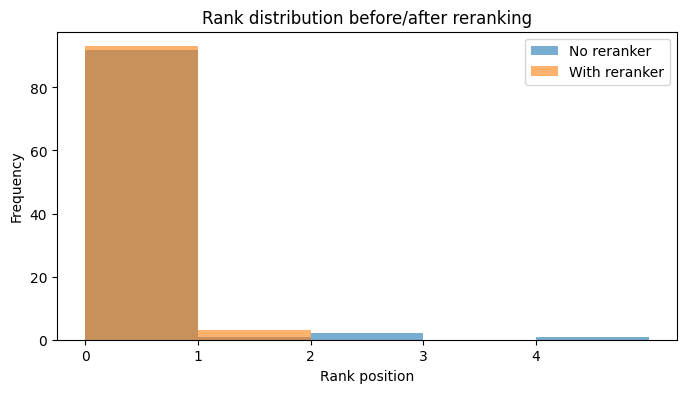

In [ ]:
plt.figure(figsize=(8,4))
df_eval_no_nf = df_eval[(df_eval["NO_RERANKER"] != 'not found') & (df_eval["WITH_RERANKER"] != 'not found')]

plt.hist(df_eval_no_nf["NO_RERANKER"], bins=range(6), alpha=0.6, label="No reranker")
plt.hist(df_eval_no_nf["WITH_RERANKER"], bins=range(6), alpha=0.6, label="With reranker")
plt.xticks(range(5))
plt.xlabel("Rank position")
plt.ylabel("Frequency")
plt.legend()
plt.title("Rank distribution before/after reranking")
plt.show()


### **Question 1.** Did reranking improve the **average position** of the correct news?


YOUR WRITTEN RESPONSE HERE

Yes, reranking significantly improved the average position of the correct news. The mean rank decreased from 0.09375 without reranking to 0.030303030303030304 with reranking. This represents approximately a 68% improvement in average position, meaning the correct news articles are appearing much higher in the ranked results after reranking. Lower mean rank values indicate better performance since they show the relevant documents are positioned closer to the top of the results.

### **Question 2.** How often was the correct article at **position 0** with and without reranking?


YOUR WRITTEN RESPONSE HERE

The correct article appeared at position 0 (top result) 92 times out of 100 without reranking, compared to 96 times out of 100 with reranking. This means the reranker improved the top-1 accuracy by 4 additional correct results, increasing the success rate from 92% to 96%.